In [1]:
import pandas as pd
import numpy as np
import os
import shutil
from tqdm import tqdm
from glob import glob
import librosa

# Data pre-processing

In [2]:
# 원본 파일 불러오기
sample_submission = pd.read_csv("./data/sample_submission.csv")

africa_train_paths = glob("./data/train/africa/*.wav")
australia_train_paths = glob("./data/train/australia/*.wav")
canada_train_paths = glob("./data/train/canada/*.wav")
england_train_paths = glob("./data/train/england/*.wav")
hongkong_train_paths = glob("./data/train/hongkong/*.wav")
us_train_paths = glob("./data/train/us/*.wav")

path_list = [africa_train_paths, australia_train_paths, canada_train_paths,
             england_train_paths, hongkong_train_paths, us_train_paths]

In [14]:
# glob로 test data의 path를 불러옴. 순서대로 로드되지 않을 경우를 주의
# test_ 데이터 프레임을 만들어 나중에 sample_submission과 id를 기준으로 merge시킬 준비

def get_id(data):
    return int(os.path.split(data)[-1].split(".")[0])

test_ = pd.DataFrame(index = range(0, 6100), columns = ["path", "id"])
test_["path"] = glob("./data/test/*.wav")
test_["id"] = test_["path"].apply(lambda x : get_id(x))

test_.head()

,path,id
0,./data/test/4737.wav,4737
1,./data/test/793.wav,793
2,./data/test/1961.wav,1961
3,./data/test/5574.wav,5574
4,./data/test/1618.wav,1618


In [15]:
def load_data(paths):

    result = []
    for path in tqdm(paths):
        # sr = 1초당 16000개의 데이터를 샘플링
        data, sr = librosa.load(path, sr = 16000)
        result.append(data)
    result = np.array(result, dtype=object) 

    return result

In [16]:
# npy 형식으로 변환 후 저장
africa_train_data = load_data(africa_train_paths)
np.save("./npy_data/africa_npy", africa_train_data)

australia_train_data = load_data(australia_train_paths)
np.save("./npy_data/australia_npy", australia_train_data)

canada_train_data = load_data(canada_train_paths)
np.save("./npy_data/canada_npy", canada_train_data)

england_train_data = load_data(england_train_paths)
np.save("./npy_data/england_npy", england_train_data)

hongkong_train_data = load_data(hongkong_train_paths)
np.save("./npy_data/hongkong_npy", hongkong_train_data)

us_train_data = load_data(us_train_paths)
np.save("./npy_data/us_npy", us_train_data)

test_data = load_data(test_["path"])
np.save("./npy_data/test_npy", test_data)

100%|██████████| 6100/6100 [15:52<00:00,  6.41it/s]


In [3]:
# npy파일로 저장된 데이터를 불러오기
africa_train_data = np.load("./npy_data/africa_npy.npy", allow_pickle = True)
australia_train_data = np.load("./npy_data/australia_npy.npy", allow_pickle = True)
canada_train_data = np.load("./npy_data/australia_npy.npy", allow_pickle = True)
england_train_data = np.load("./npy_data/england_npy.npy", allow_pickle = True)
hongkong_train_data = np.load("./npy_data/hongkong_npy.npy", allow_pickle = True)
us_train_data = np.load("./npy_data/us_npy.npy", allow_pickle = True)

test_data = np.load("./npy_data/test_npy.npy", allow_pickle = True)

train_data_list = [africa_train_data, australia_train_data, canada_train_data, england_train_data, hongkong_train_data, us_train_data]
train_x = np.concatenate(train_data_list, axis= 0)
test_x = np.array(test_data)

In [8]:
# data의 최소 길이를 구하는 함수
def get_minimum_length(data):
    mini = np.Inf
    for i in data:
        if len(i) < mini:
            mini = len(i)
    return mini

# 모든 데이터를 최소 길이로 자르는 함수 
def set_length(data_array, minimum_length):
    result = np.zeros((len(data_array), minimum_length), dtype=np.float32)
    for i, data in enumerate(data_array):
        result[i] = data[:minimum_length]
    result = np.asarray(result, dtype=np.float32)
    return result

# 특징 추출
def get_feature(data_array, sr = 16000, n_fft = 256, win_length = 200, hop_length = 160, n_mels = 64):
    mel = [None] * len(data_array)
    for i, data in enumerate(data_array):
        # win_length = 음성을 작은 조각으로 자를때 작은 조각의 크기
        # hop_length = 음성을 작은 조각으로 자를때 자르는 간격
        # n_mels = 적용할 mel filter의 개수
        mel[i] = librosa.feature.melspectrogram(data, sr = sr, n_fft = n_fft, win_length = win_length, hop_length = hop_length, n_mels = n_mels)
    mel = np.asarray(mel, dtype=np.float32)
    mel = librosa.power_to_db(mel, ref = np.max)

    # Standard scaling
    mel_mean = mel.mean()
    mel_std = mel.std()
    mel = (mel - mel_mean) / mel_std

    return mel

In [9]:
# 음성의 길이 중 가장 작은 길이를 구함
train_minimum_length = get_minimum_length(train_x)
test_minimum_length = get_minimum_length(test_x)
minimum_length = np.min([train_minimum_length, test_minimum_length])

# data의 길이를 가장 작은 길이에 맞춰 자름
train_x = set_length(train_x, minimum_length)
test_x = set_length(test_x, minimum_length)

# librosa를 이용해 feature를 추출
train_x = get_feature(train_x)
test_x = get_feature(test_x)


train_x = train_x.reshape(-1, train_x.shape[1], train_x.shape[2], 1)
test_x = test_x.reshape(-1, test_x.shape[1], test_x.shape[2], 1)
# train_data의 label을 생성
train_y = np.concatenate((np.zeros(len(africa_train_data), dtype = int),
                        np.ones(len(australia_train_data), dtype = int),
                         np.ones(len(canada_train_data), dtype = int) * 2,
                         np.ones(len(england_train_data), dtype = int) * 3,
                         np.ones(len(hongkong_train_data), dtype = int) * 4,
                         np.ones(len(us_train_data), dtype = int) * 5), axis = 0)

In [17]:
np.save("./npy_data/train_x", train_x)
np.save("./npy_data/train_y", train_y)
np.save("./npy_data/test_x", test_x)


# Load pre-processed data

In [2]:
train_x = np.load("./npy_data/train_x.npy")
train_y = np.load("./npy_data/train_y.npy")
test_x = np.load("./npy_data/test_x.npy")

print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_x.shape, test_x.dtype)

(25520, 64, 501, 1) float32
(25520,) int64
(6100, 64, 501, 1) float32


# CNN MODEL

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Convolution2D, BatchNormalization, Flatten,
                                     Dropout, Dense, AveragePooling2D, Add)
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [4]:
def block(input_, units=32, dropout_rate=0.5):
    x = Convolution2D(units, 3, padding="same", activation="relu")(input_)
    x = BatchNormalization()(x)
    x_res = x
    x = Convolution2D(units, 3, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Convolution2D(units, 3, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Add()([x, x_res])
    x = AveragePooling2D()(x)
    x = Dropout(rate=dropout_rate)(x)

    return x


def second_block(input_, units=64, dropout_rate=0.5):

    x = Convolution2D(units, 1, padding="same", activation="relu")(input_)
    x = Convolution2D(units, 3, padding="same", activation="relu")(x)
    x = Convolution2D(units * 4, 1, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x_res = x
    x = Convolution2D(units, 1, padding="same", activation="relu")(x)
    x = Convolution2D(units, 3, padding="same", activation="relu")(x)
    x = Convolution2D(units * 4, 1, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Convolution2D(units, 1, padding="same", activation="relu")(x)
    x = Convolution2D(units, 3, padding="same", activation="relu")(x)
    x = Convolution2D(units * 4, 1, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Add()([x, x_res])
    x = AveragePooling2D()(x)
    x = Dropout(rate=dropout_rate)(x)

    return x


In [5]:
def build_fn():
    dropout_rate = 0.3

    in_ = Input(shape=(train_x.shape[1:]))

    block_01 = block(in_, units=32, dropout_rate=dropout_rate)
    block_02 = block(block_01, units=64, dropout_rate=dropout_rate)
    block_03 = block(block_02, units=128, dropout_rate=dropout_rate)

    block_04 = second_block(block_03, units=64, dropout_rate=dropout_rate)
    block_05 = second_block(block_04, units=128, dropout_rate=dropout_rate)

    x = Flatten()(block_05)

    x = Dense(units=128, activation="relu")(x)
    x = BatchNormalization()(x)
    x_res = x
    x = Dropout(rate=dropout_rate)(x)

    x = Dense(units=128, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Add()([x_res, x])
    x = Dropout(rate=dropout_rate)(x)

    model_out = Dense(units=6, activation='softmax')(x)
    model = Model(in_,model_out)

    return model


In [7]:
split = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 10)

pred = []
pred_ = []

loss_list = []
acc_list = []
val_loss_list = []
val_acc_list = []

for train_idx, val_idx in split.split(train_x, train_y):
    x_train, y_train = train_x[train_idx], train_y[train_idx]
    x_val, y_val = train_x[val_idx], train_y[val_idx]

    model = build_fn()
    model.compile(optimizer = keras.optimizers.Adam(0.0003),
                 loss = keras.losses.SparseCategoricalCrossentropy(),
                 metrics = ['acc'])

    # callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
    # modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./model/best_model.h5', monitor='val_loss', save_best_only=True)


    history = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs = 15, batch_size=64)
    print("*******************************************************************")
    
    # model.load_weights("./model/best_model.h5") # 저장된 모델 불러들이기
    pred.append(model.predict(test_x))
    pred_.append(np.argmax(model.predict(test_x), axis = 1))

    loss_list.append(history.history['loss'])
    acc_list.append(history.history['acc'])
    val_loss_list.append(history.history['val_loss'])
    val_acc_list.append(history.history['val_acc'])
    print("*******************************************************************")

Epoch 1/15
319/319 [==============================] - 64s 193ms/step - loss: 2.4286 - acc: 0.2334 - val_loss: 1.4639 - val_acc: 0.3924
Epoch 2/15
319/319 [==============================] - 61s 191ms/step - loss: 1.6536 - acc: 0.3811 - val_loss: 1.3544 - val_acc: 0.4591
Epoch 3/15
319/319 [==============================] - 61s 192ms/step - loss: 1.4655 - acc: 0.4324 - val_loss: 1.3287 - val_acc: 0.4736
Epoch 4/15
319/319 [==============================] - 62s 193ms/step - loss: 1.3747 - acc: 0.4706 - val_loss: 1.2714 - val_acc: 0.4986
Epoch 5/15
319/319 [==============================] - 62s 194ms/step - loss: 1.2702 - acc: 0.5126 - val_loss: 1.3945 - val_acc: 0.4465
Epoch 6/15
319/319 [==============================] - 62s 195ms/step - loss: 1.1864 - acc: 0.5408 - val_loss: 1.1853 - val_acc: 0.5553
Epoch 7/15
319/319 [==============================] - 62s 194ms/step - loss: 1.1089 - acc: 0.5817 - val_loss: 1.1691 - val_acc: 0.5492
Epoch 8/15
319/319 [==============================] - 6

In [8]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 64, 501, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 64, 501, 32)  320         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 64, 501, 32)  128         conv2d_135[0][0]                 
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 64, 501, 32)  9248        batch_normalization_85[0][0]     
____________________________________________________________________________________________

In [9]:
print(len(loss_list[0]))
print(len(acc_list[1]))
print(len(val_loss_list))
print(len(val_acc_list))

15
15
5
5


In [10]:
import matplotlib.pyplot as plt

def plot_history(history_dict):
    for i in range(len(loss_list)):
        loss = loss_list[i]
        val_loss = val_loss_list[i]

        epochs = range(1, len(loss) + 1)
        fig = plt.figure(figsize=(14, 5))

        print("-------------------------------------------------------------------------------------------------------------")
        print("{} 번째 Model\n".format(i+1))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.plot(epochs, loss_list[i], 'b--', label='train_loss')
        ax1.plot(epochs, val_loss_list[i], 'r:', label='val_loss')
        ax1.set_facecolor('white') 
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        ax1.legend()

        acc = acc_list[i]
        val_acc = val_acc_list[i]

        ax2 = fig.add_subplot(1, 2, 2)
        ax2.plot(epochs, acc_list[i], 'b--', label='train_accuracy')
        ax2.plot(epochs, val_acc_list[i], 'r:', label='val_accuracy')
        ax2.set_facecolor('white') 
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.grid(True)
        ax2.legend()

        plt.show()

-------------------------------------------------------------------------------------------------------------
1 번째 Model



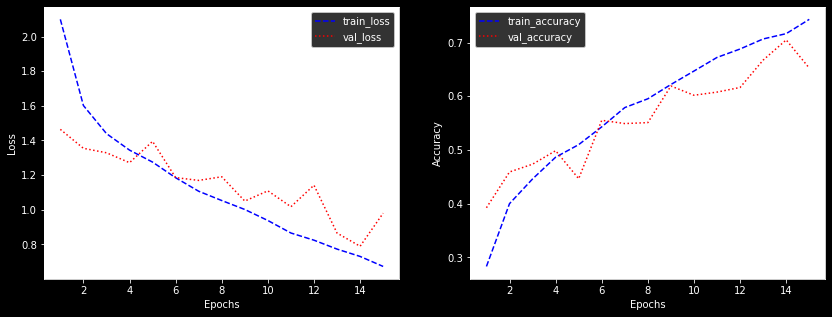

-------------------------------------------------------------------------------------------------------------
2 번째 Model



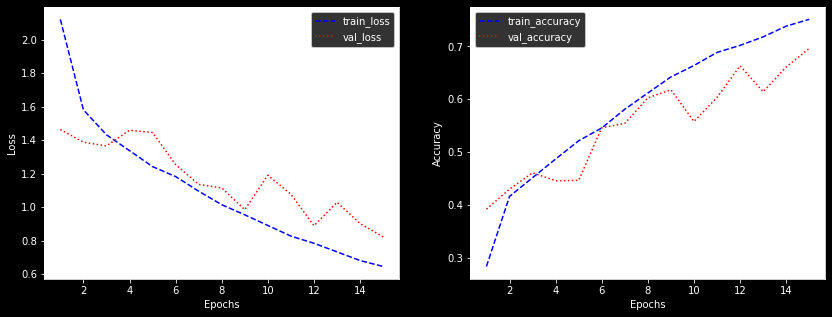

-------------------------------------------------------------------------------------------------------------
3 번째 Model



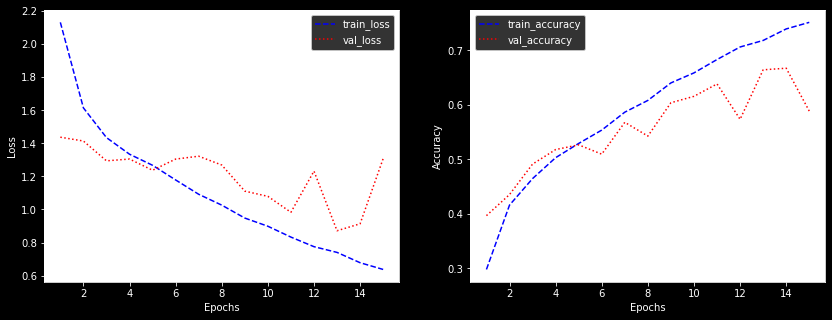

-------------------------------------------------------------------------------------------------------------
4 번째 Model



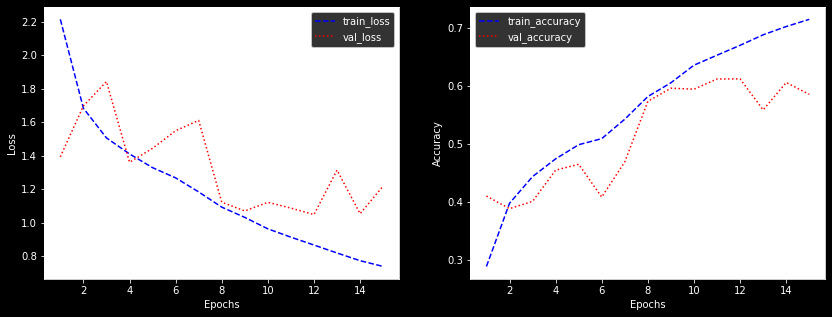

-------------------------------------------------------------------------------------------------------------
5 번째 Model



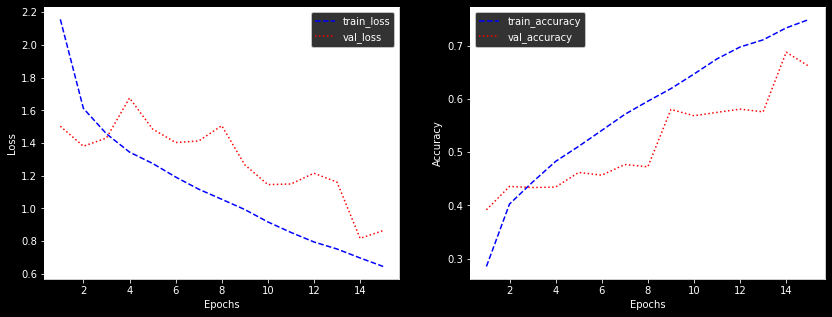

In [11]:
plot_history(history.history)

In [12]:
sample_submission = pd.read_csv("./data/sample_submission.csv")

In [15]:
def cov_type(data):
    return np.int(data)

# glob로 로드한 test data의 path는 sample_submission의 id와 같이 1,2,3,4,5 순으로 정렬 되어있지 않음
# 만들어둔 test_ 데이터프레임을 이용하여 sample_submission과 predict값의 id를 맞춰줌

result = pd.concat([test_, pd.DataFrame(np.mean(pred, axis = 0))], axis = 1).iloc[:, 1:]
result["id"] = result["id"].apply(lambda x : cov_type(x))

result = pd.merge(sample_submission["id"], result)
result.columns = sample_submission.columns

<ipython-input-15-1a481ec17b83>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.int(data)


In [16]:
result.to_csv(os.path.join('result', 'test_k_d0.3_lr0.0003_e15_bat64_0604_0823.csv'), index = False)
result

,id,africa,australia,canada,england,hongkong,us
0,1,0.110171,0.184309,0.158368,0.015075,0.051781,0.480295
1,2,0.010345,0.091507,0.061506,0.348782,0.013573,0.474286
2,3,0.123814,0.015075,0.015371,0.644526,0.000766,0.200448
3,4,0.024301,0.137588,0.152202,0.220827,0.010984,0.454098
4,5,0.057602,0.013965,0.017461,0.332416,0.016716,0.561841
...,...,...,...,...,...,...,...
6095,6096,0.045261,0.213198,0.200542,0.024544,0.221895,0.294560
6096,6097,0.002302,0.005180,0.005456,0.242939,0.000338,0.743785
6097,6098,0.062939,0.009237,0.006161,0.547400,0.001164,0.373099
6098,6099,0.026170,0.016796,0.013879,0.391525,0.006817,0.544814
